# Empirical Comparaison of Dyna and Actor Critic

In [1]:
import matplotlib
%matplotlib inline

import gym
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import sklearn.pipeline
import sklearn.preprocessing
import pdb

from heapq import *
from sklearn.kernel_approximation import RBFSampler

In [2]:
#env = gym.envs.make("CartPole-v1")
env = gym.envs.make("MountainCar-v0")

# based on https://github.com/dennybritz/reinforcement-learning/blob/master/FA/Q-Learning%20with%20Value%20Function%20Approximation%20Solution.ipynb

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

n_components = 10

featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
        ])
featurizer.fit(scaler.transform(observation_examples))


[2017-03-23 22:31:48,649] Making new env: MountainCar-v0


FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=10, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=10, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=10, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=10, random_state=None))],
       transformer_weights=None)

In [3]:
def featurize_state(state):
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0].reshape(n_components*4,1)

def getTDerror(r, gamma, theta, phi, phi1):    
    delta = r+gamma*np.dot(theta.T,phi1)-np.dot(theta.T,phi)
    return delta
    
def policy_prob(phi, weights, theta, epsilon=0.1, nA=3):
    prob = np.ones(nA) * epsilon / (nA-1)
    values = np.array([np.dot(b.T, phi)+gamma*np.dot(theta.T, np.dot(F, phi)) for b,F in weights])
    idx = np.argmax(values)
    prob[idx] = 1-epsilon
    return prob

# Linear Dyna for Control

* We learn the model dynamics $(F_a, b_a)$ following action $a$ at the same time as the weights $\theta$ of the linear value function. 
* The algorithm then goes through a sequence of $p$ planning steps.
    * Starting from a sample observed feature vector $\phi$, a reward $r$ following action $a$
    * It generates a transition ($\phi'$ and $r'$) and do conventional updates.


In [41]:
theta = np.zeros((n_components*4,1))

weights = []
for _ in range(env.action_space.n):
    F = np.zeros((4*n_components,4*n_components))
    b = np.zeros((4*n_components,1))
    weights.append([b, F])


gamma = 0.99
p_times = 5
alpha_0 = 0.001
nb_episodes = 250

rewards_DYNA = np.zeros(nb_episodes)
pred_errors = np.zeros(nb_episodes)
steps_tot = 0
alpha= alpha_0
for episode in range(nb_episodes):
    s = env.reset()
    phi = featurize_state(s)

    for steps in itertools.count():
        steps_tot += 1
        #alpha = alpha_0*(steps_tot+1)/(steps_tot+(episode+1)**1.1)
        action_probs = policy_prob(phi, weights, theta, epsilon=0.1, nA=env.action_space.n)
        a = np.random.choice(range(len(action_probs)), p=action_probs)
 
        s1,r,done,_ = env.step(a)
        phi1 = featurize_state(s1)
        rewards_DYNA[episode] += r
        
        if done:
            phi1 *= 0
        
        delta = r+gamma*np.dot(phi1.T, theta) - np.dot(phi.T, theta) # TD error
        theta += alpha*delta*phi # theta

        pred_error = (phi1-np.dot(weights[a][1], phi))
        pred_errors[episode] += np.sum(pred_error**2)
        weights[a][1] += alpha*np.dot(pred_error,phi.T) # F
        weights[a][0] += alpha*(r-np.dot(weights[a][0].T, phi))*phi # b
        
        if done: 
            break

        h = []
        for i in np.where(phi!=0)[0]:     
            heappush(h, (-np.abs(phi[i]*gamma), i))
            
        for p in range(p_times):  
            i = heappop(h)[1]

            idx = np.asarray(np.where(weights[0][1][i,]!=0))
            idx1 = np.asarray(np.where(weights[1][1][i,]!=0))
            idx_unique = np.unique(np.concatenate([idx, idx1],axis=1))
            #values = np.zeros((40,3))
            for j in idx_unique:
                e = np.zeros(4*n_components)
                e[j] = 1
                values = np.array([b+gamma*np.dot(theta.T, F).T for b, F in weights])

                delta = np.max(values[:,j,:]-theta[j])
                
                theta[j] += alpha*delta
            
                heappush(h, (-np.abs(gamma), j))

        phi = phi1
    alpha *= 0.95
        
print "Done"

Done


In [44]:
theta = np.zeros((n_components*4,1))

weights = []
for _ in range(env.action_space.n):
    F = np.zeros((4*n_components,4*n_components))
    b = np.zeros((4*n_components,1))
    weights.append([b, F])


gamma = 0.99
p_times = 5
alpha_0 = 0.001#25
nb_episodes = 250

rewards_DYNA = np.zeros(nb_episodes)
pred_errors = np.zeros(nb_episodes)
steps_tot = 0
alpha= alpha_0


for episode in range(nb_episodes):
    s = env.reset()
    phi = featurize_state(s)

    for steps in itertools.count():
        #alpha = alpha_0*(steps+1)/(steps+(episode+1)**1.1)
        action_probs = policy_prob(phi, weights, theta, epsilon=0.1, nA=env.action_space.n)
        a = np.random.choice(range(len(action_probs)), p=action_probs)
 
        s1,r,done,_ = env.step(a)
        phi1 = featurize_state(s1)
        rewards_DYNA[episode] += r
        
        if done:
            phi1 *= 0
        
        delta = r+gamma*np.dot(phi1.T, theta) - np.dot(phi.T, theta) # TD error
        theta += alpha*delta*phi # theta

        pred_error = (phi1-np.dot(weights[a][1], phi))
        pred_errors[episode] += np.sum(pred_error**2)
        weights[a][1] += alpha*np.dot(pred_error,phi.T) # F
        weights[a][0] += alpha*(r-np.dot(weights[a][0].T, phi))*phi # b
        
        if done: 
            break


        for p in range(p_times):
            s_sample = observation_examples[np.random.randint(0,10000),]
            phi_sample = featurize_state(s_sample)
            action_probs = policy_prob(phi_sample, weights, theta, epsilon=0.1, nA=env.action_space.n)
            a = np.random.choice(range(len(action_probs)), p=action_probs)
            phi_sim = np.dot(weights[a][1], phi_sample)
            r_sim = np.dot(weights[a][0].T, phi_sample)
            
            delta = r_sim+gamma*np.dot(phi_sim.T, theta) - np.dot(phi_sample.T, theta) # TD error
            theta += alpha*delta*phi_sample # theta

        phi = phi1
        
print "Done"

Done


# One-step Actor Critic (AC)

* AC is a policy gradient method i.e. it estimates the probability over actions in a given state.
* The actor is the action value estimate and the critic the state value estimate.
* After each action, the critic evaluates if things have gone better or worst than expected (TD error). If the TD error is positive, we increase the probability of the critic of taking this action in the future. 

In [5]:
def featurize_state_tf(state):
    scaled = scaler.transform([state])
    featurized = featurizer.transform(scaled)
    return featurized[0].reshape(1, n_components*4)

In [6]:
import tensorflow as tf

class policyNetwork():
    def __init__(self):
        self.inputs = tf.placeholder(dtype=tf.float32,shape=(None,4*n_components))
        self.action = tf.placeholder(dtype=tf.int32)
        self.target = tf.placeholder(dtype=tf.float32)
        self.W1 = tf.get_variable("W1_policy",shape=[4*n_components, env.action_space.n],
           initializer=tf.contrib.layers.xavier_initializer())
        
        self.h1 = tf.matmul(self.inputs,self.W1)

        self.action_probs = tf.squeeze(tf.nn.softmax(self.h1))
        self.action_picked_probs = tf.gather(self.action_probs, self.action)
        self.loss = -tf.log(self.action_picked_probs) * self.target
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
        
        self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
             
    def predict(self, state):
        #sess = tf.get_default_session()
        return sess.run(self.action_probs, {self.inputs: state})
    
    def update(self, state, action, target):
        #sess = tf.get_default_session()
        feed_dict = {self.inputs:state, self.target:target , self.action:action}
        _,loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss
    
class valueNetwork():
    def __init__(self):
        self.inputs = tf.placeholder(dtype=tf.float32,shape=(None,4*n_components))
        self.target = tf.placeholder(dtype=tf.float32)
        self.W1 = tf.get_variable("W1_value", shape=[4*n_components, 1],
           initializer=tf.contrib.layers.xavier_initializer())
        
        self.h1 = tf.matmul(self.inputs,self.W1)

        self.value_estimate = tf.squeeze(self.h1)

        self.loss = tf.squared_difference(self.value_estimate, self.target)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
        
        self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state):
        return sess.run(self.value_estimate, {self.inputs: state})
    
    def update(self,state,target):
        feed_dict = {self.inputs:state, self.target:target}
        _,loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [7]:
tf.reset_default_graph()


value_net = valueNetwork()
policy_net = policyNetwork()

rewards_AC = np.zeros(nb_episodes)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for episode in range(nb_episodes):
        s = env.reset()
        phi = featurize_state_tf(s)
        I = 1
        for steps in itertools.count():
            action_probs = policy_net.predict(phi)
            a = np.random.choice(range(len(action_probs)), p=action_probs)
        
            s1,r,done,_ = env.step(a)
            phi1 = featurize_state_tf(s1)
            rewards_AC[episode] += r
        
            if done:
                phi1 *= 0
        
            target = r+gamma*value_net.predict(phi1)
            delta = target-value_net.predict(phi)
            policy_net.update(phi,a,delta)
            value_net.update(phi,target)
            
            if done: 
                break
                
            I *= gamma
            phi = phi1
            
print "Done"

/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Done


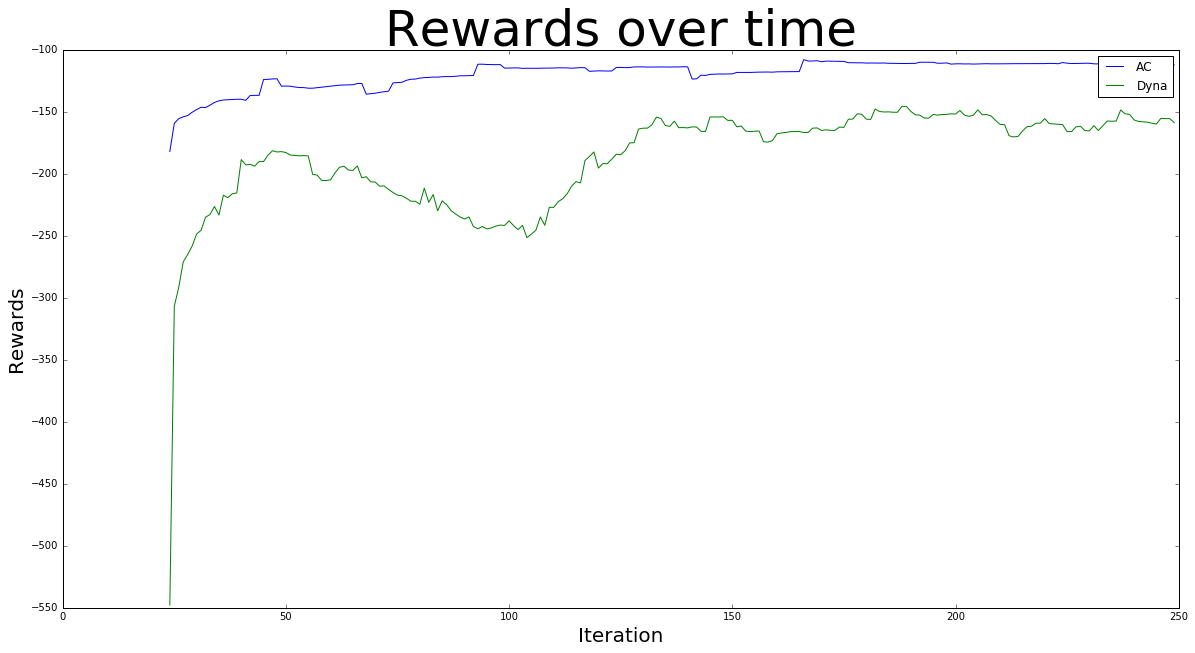

In [45]:
fig = plt.figure(figsize=(20, 10))

AC, = plt.plot(pd.rolling_mean(rewards_AC,25), label="AC")
DYNA, = plt.plot(pd.rolling_mean(rewards_DYNA,25), label="Dyna")

plt.title("Rewards over time", fontsize=50)
ax = fig.add_subplot(111)
ax.set_xlabel('Iteration',fontsize = 20)
ax.set_ylabel('Rewards', fontsize = 20)

plt.legend(handles=[AC, DYNA])
plt.show()